In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [ ]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/Flickr_Data/Flickr_TextData')

In [ ]:
!ls

CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt  Flickr_8k.trainImages.txt
ExpertAnnotations.txt	    Flickr_8k.testImages.txt  readme.txt
Flickr_8k.devImages.txt     Flickr8k.token.txt


In [ ]:
def readTextFile(path):
  with open(path) as f:
    captions = f.read()
    return captions



In [ ]:
captions = readTextFile('Flickr8k.token.txt')
captions = captions.split("\n")[:-1]        #Since last caption is null, hence we remove the last caption from the whole dataset.
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
#Dictionary to map each image with the list of captions it has.

descriptions = {}

for x in captions :
  first,second = x.split('\t')
  img_name = first.split('.')[0]

  #if the image id is already present or not
  if descriptions.get(img_name) is None:
    descriptions[img_name] = []

  descriptions[img_name].append(second)


In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
os.chdir('/content/drive/My Drive/Flickr_Data')
!ls

descriptions_1.txt	    flickr8ktextfiles  Images
encoded_test_features.pkl   Flickr_TextData    model_weights
encoded_train_features.pkl  glove.6B.50d.txt


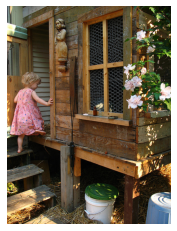

In [ ]:
IMG_PATH = "Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

# Data Cleaning

In [ ]:
def clean_text(sentence):
  sentence = sentence.lower()
  #Now we substitute all the punctuations and special symbols by a space 
  sentence = re.sub("[^a-z]+"," ",sentence)       # 're' here is the regular expression, [^a-z] means any character that is not between a to z, [^a-z]+ means one or more occurences of that character which is not an alphabet
  
  #Now to further reduce the vocab size, we decide to remove words whose length is equal to 1 
  sentence = sentence.split()
  sentence = [s for s in sentence if len(s)>1]
  sentence = " ".join(sentence)

  return sentence

In [ ]:
clean_text('A cat is sitting over the house # 33')

'cat is sitting over the house'

In [ ]:
#Now we will clean all the captions by calling the above defined function 
for key,caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i] = clean_text(caption_list[i])
    

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
#Now we store these pre-processed captions in a text file
#Writing a text file
with open('descriptions_1.txt',"w") as f:
  f.write(str(descriptions))


# Vocabulary

In [ ]:
#Reading the cleaned descriptions from the stored file. (Although it is not necessary to store these captions in a separate file. We just did this in case we want to skip our preprocessing part and directly load the cleaned descriptions.)
descriptions = None
with open('descriptions_1.txt') as f:
  descriptions = f.read()
  #Now we will you the json load method to convert this string into a dictionary
  #To convert this txt file into a json acceptable string we need to replace all the single quotes in the string by a back slash(\).
  json_acceptable_string = descriptions.replace("'","\"")
  descriptions = json.loads(json_acceptable_string)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
#To make the vocab we are going to use a python inbuilt data structure called SET. Set is used to store all the unique words.
vocab = set()
for key in descriptions.keys():
  [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab Size is %d"%len(vocab))

Vocab Size is 8424


In [ ]:
#Total words in our dataset : unique + duplicate 
total_words = []
for key in descriptions.keys():
  [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total words in our dataset are %d"%len(total_words))

Total words in our dataset are 373837


In [ ]:
#Filtering words from the vocab ccording to a certain threshold frequency

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)
print(len(freq_cnt.keys()))

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [ ]:
#Sort this dictionary according to the frequency count
sorted_freq_cnt = sorted(freq_cnt.items(), key = lambda x:x[1], reverse=True)

#Filter according to the threshold
threshold = 10            #All the words which appear less than 10 times in the whole dataset will be removed from our vocab.
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>10]
total_words = [x[0] for x in sorted_freq_cnt]
print(len(total_words))
# So we get a total of 1845 unique words in our vocabulary.



1845


# Prepare Train/Test Data

In [ ]:
train_file_data = readTextFile('Flickr_TextData/Flickr_8k.trainImages.txt')  
test_file_data = readTextFile('Flickr_TextData/Flickr_8k.testImages.txt')  

In [ ]:
train = [row.split('.')[0] for row in train_file_data.split('\n')][:-1]
test = [row.split('.')[0] for row in test_file_data.split('\n')][:-1]

In [ ]:
len(test)

1000

In [ ]:
# Prepare description for the training data
# Tweak : Add <s> and <e> tokens to the sentences
train_descriptions={}

for img_id in train:
  train_descriptions[img_id] = []
  for cap in descriptions[img_id]:
    cap_to_append = 'startseq '+ cap + ' endseq'
    train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer Learning
* Images --> Features
* Text ---> Features

## Step-1 : Image Feature Extraction (Data preprocessing - Images)

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)
#model_new.summary()

In [ ]:
def preprocess_img(img):
  img = image.load_img(img,target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)        #When you feed an image of size (224,224,3) to your ResNet-50 model, you cannot feed a single image. You have to feed in certain batch. Our shape should be like (batch_size,224,224,3) i.e. a 4D tensor. So to convert a single image of (224,224,3) into a 4D tensor, we use expamd dims function which expands your dimension along axis=0. So by default it would reshape the single image into (1,224,224,3) i.e. a 4D tensor. 

  #Normalisation (will be taken care by the preprocess_input function which was used while ResNet was trained on imagenet dataset)
  img = preprocess_input(img)
  return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


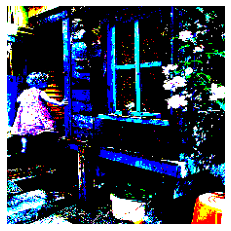

In [ ]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])        #Since it is a 4D tensor, hence we have to index it by a [0].
plt.axis('off')
plt.show()

In [ ]:
#Now after preprocessing we will pass this preprocessed image through the ResNet-50 model to extract the features and then store them in a file.
def encode_image(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((-1,))
  return feature_vector

In [ ]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154297, 0.17076068, 0.2927861 , ..., 0.05089626, 0.3132238 ,
       0.86007506], dtype=float32)

In [ ]:
#Now we will create a dictionary which would map the image ids to the corresponding feature vector coming as output from the ResNet-50 model.
start = time()
encoding_train = {}

for ix,img_id in enumerate(train):
  img_path = IMG_PATH + '/' + img_id + '.jpg'
  encoding_train[img_id] = encode_image(img_path)

  if ix%100==0:
    print("Encoding in progress Time Step %d "%ix)

end = time()
print("Total Time Taken : %d "%(end-start))

Encoding in progress Time Step 0 
Encoding in progress Time Step 100 
Encoding in progress Time Step 200 
Encoding in progress Time Step 300 
Encoding in progress Time Step 400 
Encoding in progress Time Step 500 
Encoding in progress Time Step 600 
Encoding in progress Time Step 700 
Encoding in progress Time Step 800 
Encoding in progress Time Step 900 
Encoding in progress Time Step 1000 
Encoding in progress Time Step 1100 
Encoding in progress Time Step 1200 
Encoding in progress Time Step 1300 
Encoding in progress Time Step 1400 
Encoding in progress Time Step 1500 
Encoding in progress Time Step 1600 
Encoding in progress Time Step 1700 
Encoding in progress Time Step 1800 
Encoding in progress Time Step 1900 
Encoding in progress Time Step 2000 
Encoding in progress Time Step 2100 
Encoding in progress Time Step 2200 
Encoding in progress Time Step 2300 
Encoding in progress Time Step 2400 
Encoding in progress Time Step 2500 
Encoding in progress Time Step 2600 
Encoding in p

In [ ]:
# Store everything to the disk as it takes a long time to do this and we don't want to lose this information
# So we will use pickle to dump our data into a file

with open("encoded_train_features.pkl","wb") as f:
  pickle.dump(encoding_train,f)


In [ ]:
# Now we will do the same and store everything for test images as well. These feature vectors for test images will be used during the predictions. 

#Now we will create a dictionary which would map the image ids to the corresponding feature vector coming as output from the ResNet-50 model.
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
  img_path = IMG_PATH + '/' + img_id + '.jpg'
  encoding_test[img_id] = encode_image(img_path)

  if ix%100==0:
    print("Test Encoding in progress Time Step %d "%ix)

end = time()
print("Total Time Taken(test) : %d "%(end-start))


Test Encoding in progress Time Step 0 
Test Encoding in progress Time Step 100 
Test Encoding in progress Time Step 200 
Test Encoding in progress Time Step 300 
Test Encoding in progress Time Step 400 
Test Encoding in progress Time Step 500 
Test Encoding in progress Time Step 600 
Test Encoding in progress Time Step 700 
Test Encoding in progress Time Step 800 
Test Encoding in progress Time Step 900 
Total Time Taken(test) : 679 


In [ ]:
with open("encoded_test_features.pkl","wb") as f:
  pickle.dump(encoding_test,f)

# Step 2 : Data Preprocessing - Captions 

In [ ]:
# Vocab
len(total_words)

1845

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word

word_to_idx['dog']

6

In [ ]:
#Now we add the 2 special words to our dictionary i.e. startseq and endseq
idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size : %d"%vocab_size)


Vocab Size : 1848


In [ ]:
# Finding the maximum length sentence in our training set
max_len =0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len,len(cap.split()))

print("Maximum Length of a sentence is %d"%max_len)


Maximum Length of a sentence is 35


In [ ]:
!ls

descriptions_1.txt	    flickr8ktextfiles  Images
encoded_test_features.pkl   Flickr_TextData    model_weights
encoded_train_features.pkl  glove.6B.50d.txt   storage


In [ ]:
with open("storage/word_to_idx.pkl","wb") as w2i:
  pickle.dump(word_to_idx,w2i)

with open("storage/idx_to_word.pkl","wb") as i2w:
  pickle.dump(idx_to_word,i2w)

# Data Loader (Generator)

In [ ]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
  X1,X2,y = [],[],[]

  n=0
  while True:
    for key,desc_list in train_descriptions.items():
      n += 1
      photo = encoding_train[key]
      for desc in desc_list:
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]     #If the mapping is not present , we are just going to ignore the word.

        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          #0 denoting the padding word
          xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]           #pad_sequences is a function provided by keras.
          yi = to_categorical([yi],num_classes=vocab_size)[0]                         #The output i.e each word would also be a one hot vector.

          X1.append(photo)
          X2.append(xi)
          y.append(yi)

      if n==batch_size :
        yield [[np.array(X1),np.array(X2)],np.array(y)]                                      #Remember we are not using the return function because this is a generator and generator remembers the state where the function was in the previous call. 

        
        # Now for the next function call when the control comes back to the generator function again, we initialise X1, X2, y as a empty list.
        X1,X2,y = [],[],[]
        n=0



# Word Embeddings

In [ ]:
os.getcwd()

'/content/drive/My Drive/Flickr_Data/model_weights'

In [ ]:
#Reading the glove.6B.50D.txt file and storing it's contents in a dictionary
with open('glove.6B.50d.txt') as f:
  embedding_index = {}
  for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = 'float')
    embedding_index[word]  = word_embedding

  print(embedding_index['apple'])


[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


In [ ]:
# Selecting the embeddings for the words present in our vocab
def get_embedding_matrix():
  emb_dim = 50
  matrix = np.zeros((vocab_size,emb_dim))

  for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
      matrix[idx] = embedding_vector

  return matrix



In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

# Model Architecture

In [ ]:
# The output of ResNet-50 will be going to this input layer
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)



In [ ]:
# Accepting Captions as Input
input_captions = Input(shape=(max_len,))          # We would be feeding input of shape (batch_size,max_len) , but we need to specify size of just 1 input i.e. 35.
inp_cap1 = Embedding(input_dim = vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)            # Here 256 is not the no of cells. Instead 256 denotes the output size that will be the size of the hidden vector



In [ ]:
# Adding the two 256-dimensional vector
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs = outputs)


In [ ]:
# Important Thing to do : Pre-initialize the embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False 

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

# Training of Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
!mkdir model_weights

In [ ]:
!ls

descriptions_1.txt	    flickr8ktextfiles  Images
encoded_test_features.pkl   Flickr_TextData    model_weights
encoded_train_features.pkl  glove.6B.50d.txt


In [ ]:
os.chdir('/content/drive/My Drive/Flickr_Data/model_weights')
!ls

In [ ]:
def train():
  for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)          # epoch here means how many times we want our batch to pass through the current epoch. # 
    model.save('model_'+str(i)+'.h5')


In [ ]:
train()

Epoch 1/1
2000/2000 [==============================] - 325s 163ms/step - loss: 4.3058
Epoch 1/1
2000/2000 [==============================] - 324s 162ms/step - loss: 3.5783
Epoch 1/1
2000/2000 [==============================] - 319s 159ms/step - loss: 3.3165
Epoch 1/1
2000/2000 [==============================] - 319s 159ms/step - loss: 3.1603
Epoch 1/1
2000/2000 [==============================] - 312s 156ms/step - loss: 3.0488
Epoch 1/1
2000/2000 [==============================] - 312s 156ms/step - loss: 2.9625
Epoch 1/1
2000/2000 [==============================] - 319s 160ms/step - loss: 2.8946
Epoch 1/1
2000/2000 [==============================] - 320s 160ms/step - loss: 2.8412
Epoch 1/1
2000/2000 [==============================] - 321s 160ms/step - loss: 2.7893
Epoch 1/1
2000/2000 [==============================] - 321s 160ms/step - loss: 2.7531
Epoch 1/1
2000/2000 [==============================] - 320s 160ms/step - loss: 2.7176
Epoch 1/1
2000/2000 [==============================] -

In [ ]:
model = load_model('model_9.h5')

# Predictions

In [ ]:
def predict_caption(photo):

  in_text = "startseq"
  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

    ypred = model.predict([photo,sequence])
    ypred = ypred.argmax()           # Word with the maximum probability always : Greedy Sampling

    word = idx_to_word[ypred]
    in_text += (' ' + word)

    if word=='endseq':
      break

  # Removing the 'startseq' and the 'endseq'
  final_caption = in_text.split()[1:-1]
  final_caption = " ".join(final_caption)

  return final_caption



In [ ]:
os.getcwd()

'/content/drive/My Drive/Flickr_Data/model_weights'

man in black shirt and black coat is riding unicycle


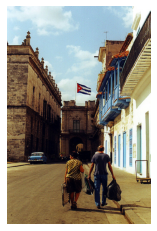

boy jumps off the air in the air


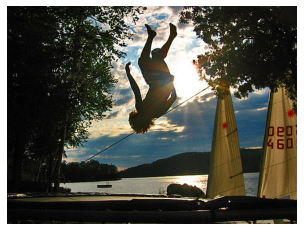

skateboarder jumps over barrel barrel


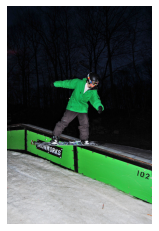

dog running through the grass


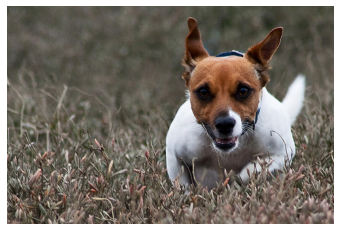

two dogs are running through field of grass


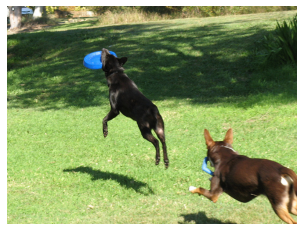

man in blue shirt and blue helmet is riding bike through the woods


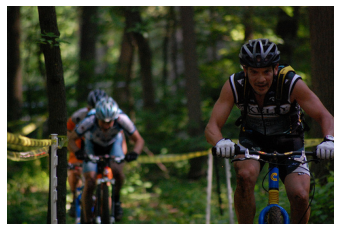

two people are standing in front of building


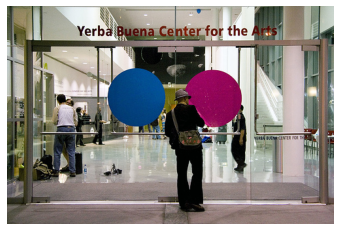

man in black shirt and black coat is riding unicycle


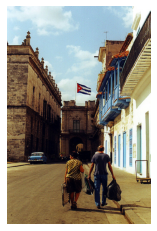

the scuba diver swims through the water


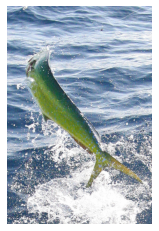

black dog is standing on its hind legs legs on the grass


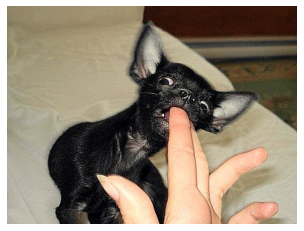

group of people are standing in front of building


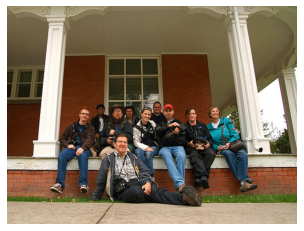

man in blue shirt and jeans is sitting on bench in front of wooden fence


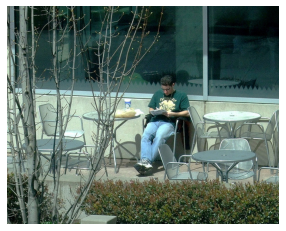

child with an orange shirt is standing in the of the of


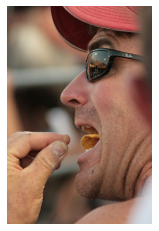

little girl in red shirt is sitting on bed with her arm around her head


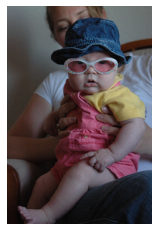

group of people are standing in front of large building


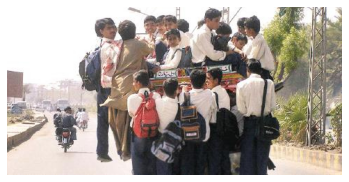

In [ ]:
# Picking some random images from the test and seeing the results 
for i in range(15):
  idx = np.random.randint(0,1000)
  all_image_names = list(encoding_test.keys())         # Encoding test is a dictionary which maps test images with their corresponding feature vectors
  img_name = all_image_names[idx]

  photo_2048 = encoding_test[img_name].reshape((1,2048))

  i = plt.imread("../Images/"+img_name+'.jpg')
  caption = predict_caption(photo_2048)
  print(caption)
  plt.imshow(i)
  plt.axis('off')
  plt.show()
